# Imports

In [1]:
import torchvision
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import json
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction 
import os
from torchvision.models.video import r3d_18  # Added for 3D ResNet

# Configuration

In [2]:
class Config:
    decoder_id = "distilbert/distilgpt2"
    max_length = 128
    batch_size = 8
    num_frames = 10
    img_size = 224
    num_epochs = 100  
    lr = 3e-5
    csv_path = "/kaggle/input/videocap/processed_data.csv"  
    grad_clip = 1.0
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15
    seed = 42
    model_save_path = "video_qa_model.pth"
    results_file = "training_results.json"
    patience = 10 
    bleu_smoothing = SmoothingFunction().method1 
    checkpoint_dir = "checkpoints" 
    save_every_epoch = False 
    final_model_path = "final_video_qa_model.pth" 
    best_checkpoint_path = os.path.join("checkpoints", "best_checkpoint.pth") 

# Dataset

In [3]:
# Cell 2: Dataset Class
class VideoQADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_tensor = self._load_video_frames(row['path'])

        text = f"Question: {row['questions']} Answer: {row['refined_answer']}"
        encoding = self.tokenizer(
            text,
            max_length=Config.max_length-1,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'video': video_tensor,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

    def _load_video_frames(self, video_path):
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            while len(frames) < Config.num_frames:
                ret, frame = cap.read()
                if not ret: break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (Config.img_size, Config.img_size))
                frames.append(frame)
            cap.release()
        except Exception as e:
            print(f"Error loading {video_path}: {e}")
            # Handle corrupted video by returning black frames instead of crashing
            return torch.zeros((Config.num_frames, 3, Config.img_size, Config.img_size))


        if not frames:
            frames = [np.zeros((Config.img_size, Config.img_size, 3), dtype=np.uint8)] * Config.num_frames

        frames = frames[:Config.num_frames]
        if len(frames) < Config.num_frames:
            frames += [frames[-1]] * (Config.num_frames - len(frames))

        video_tensor = torch.tensor(np.array(frames)).float() / 255.0
        return video_tensor.permute(0, 3, 1, 2)


# Model Architecture

In [4]:
class VideoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Load 3D ResNet-18 with pretrained weights
        self.backbone = r3d_18(pretrained=True)
        # Remove avgpool and fc layers
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool3d(1)

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Input shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        # Rearrange to (B, C, T, H, W) for 3D CNN
        x = x.permute(0, 2, 1, 3, 4)
        
        # Normalization (ImageNet stats)
        mean = torch.tensor([0.485, 0.456, 0.406]).to(x.device).view(1, 3, 1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).to(x.device).view(1, 3, 1, 1, 1)
        x = (x - mean) / std
        
        # Forward pass through 3D CNN
        features = self.backbone(x)  # (B, 512, t, h, w)
        features = self.global_pool(features)  # (B, 512, 1, 1, 1)
        return features.view(B, -1)  # Flatten to (B, 512)

class VideoQAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VideoEncoder()
        self.decoder = AutoModelForCausalLM.from_pretrained(Config.decoder_id)
        self.proj = nn.Linear(512, self.decoder.config.hidden_size)

    def forward(self, video, input_ids, attention_mask, labels=None):
        video_features = self.encoder(video)
        video_features = self.proj(video_features)

        text_embeds = self.decoder.get_input_embeddings()(input_ids)
        combined_embeds = torch.cat([video_features.unsqueeze(1), text_embeds], dim=1)
        combined_mask = torch.cat([
            torch.ones(video.size(0), 1).to(attention_mask.device),
            attention_mask
        ], dim=1)

        if labels is not None:
            labels = torch.cat([
                torch.full((input_ids.size(0), 1), -100, device=labels.device, dtype=torch.long),
                input_ids
            ], dim=1)

        return self.decoder(
            inputs_embeds=combined_embeds,
            attention_mask=combined_mask,
            labels=labels
        )

# Data Preparation

In [5]:
df = pd.read_csv(Config.csv_path)
train_df, test_df = train_test_split(
    df,
    test_size=1-Config.train_ratio,
    stratify=df['class'],
    random_state=Config.seed
)

val_df, test_df = train_test_split(
    test_df,
    test_size=Config.test_ratio/(Config.test_ratio+Config.val_ratio),
    stratify=test_df['class'],
    random_state=Config.seed
)

print(f"Dataset sizes:")
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Dataset sizes:
Train: 4766
Validation: 1022
Test: 1022


# Training Setup

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

tokenizer = AutoTokenizer.from_pretrained(Config.decoder_id)
train_dataset = VideoQADataset(train_df, tokenizer)
val_dataset = VideoQADataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=2) 
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, num_workers=2)

model = VideoQAModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=Config.lr)
scaler = torch.cuda.amp.GradScaler()


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 89.0MB/s]


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<ipython-input-6-2e7f1552e229>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Training 

In [7]:
best_val_loss = float('inf')
training_log = []
epochs_no_improve = 0 # Counter for early stopping

train_losses = [] 
val_losses = []

# Create checkpoint directory if it doesn't exist
os.makedirs(Config.checkpoint_dir, exist_ok=True)

for epoch in range(Config.num_epochs):
    # Training
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.num_epochs} [Training]")

    for batch in progress_bar:
        optimizer.zero_grad()

        video = batch['video'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)


        with torch.cuda.amp.autocast():
            outputs = model(video, input_ids, attention_mask, labels=input_ids)
            loss = outputs.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.grad_clip)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss) 


    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{Config.num_epochs} [Validating]")
        for batch in val_progress_bar:
            video = batch['video'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(video, input_ids, attention_mask, labels=input_ids) 
            val_loss += outputs.loss.item()
            val_progress_bar.set_postfix({'loss': outputs.loss.item()})

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss) 


    # Early stopping check and Best Checkpoint Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), Config.model_save_path) # Save best model based on validation loss

        # Save best checkpoint
        checkpoint_path = Config.best_checkpoint_path
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"\nEpoch {epoch+1}: Validation loss improved, saved new best model to {Config.model_save_path} and best checkpoint to {checkpoint_path}")

        epochs_no_improve = 0 
    else:
        epochs_no_improve += 1
        print(f"\nEpoch {epoch+1}: Validation loss did not improve ({epochs_no_improve}/{Config.patience})")
        if epochs_no_improve >= Config.patience:
            print(f"Early stopping triggered after {Config.patience} epochs without improvement.")
            break # Stop training loop

    # Log metrics
    epoch_log = {
        'epoch': epoch+1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss
    }
    training_log.append(epoch_log)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {epoch_log['train_loss']:.4f}")
    print(f"Val Loss: {epoch_log['val_loss']:.4f}")

Epoch 1/100 [Training]:   0%|          | 0/596 [00:00<?, ?it/s]<ipython-input-7-718089307c58>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.59it/s, loss=1.21]



Epoch 1: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 1 Summary:
Train Loss: 1.1523
Val Loss: 0.8359


Epoch 2/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.59it/s, loss=1.12]



Epoch 2: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 2 Summary:
Train Loss: 0.8201
Val Loss: 0.7644


Epoch 3/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.59it/s, loss=1.08]



Epoch 3: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 3 Summary:
Train Loss: 0.7552
Val Loss: 0.7343


Epoch 4/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.59it/s, loss=1.05]



Epoch 4: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 4 Summary:
Train Loss: 0.7127
Val Loss: 0.7125


Epoch 5/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.60it/s, loss=1.03]



Epoch 5: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 5 Summary:
Train Loss: 0.6898
Val Loss: 0.7029


Epoch 6/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.58it/s, loss=1.02]



Epoch 6: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 6 Summary:
Train Loss: 0.6724
Val Loss: 0.6934


Epoch 7/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=1.02]



Epoch 7: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 7 Summary:
Train Loss: 0.6564
Val Loss: 0.6842


Epoch 8/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.60it/s, loss=1.01]



Epoch 8: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 8 Summary:
Train Loss: 0.6390
Val Loss: 0.6821


Epoch 9/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.58it/s, loss=1.01]



Epoch 9: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 9 Summary:
Train Loss: 0.6312
Val Loss: 0.6788


Epoch 10/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.60it/s, loss=1.01]



Epoch 10: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 10 Summary:
Train Loss: 0.6228
Val Loss: 0.6729


Epoch 11/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.58it/s, loss=1]



Epoch 11: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 11 Summary:
Train Loss: 0.6107
Val Loss: 0.6696


Epoch 12/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.59it/s, loss=1.01]



Epoch 12: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 12 Summary:
Train Loss: 0.6041
Val Loss: 0.6680


Epoch 13/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=1]



Epoch 13: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 13 Summary:
Train Loss: 0.6000
Val Loss: 0.6667


Epoch 14/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=1]



Epoch 14: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 14 Summary:
Train Loss: 0.5934
Val Loss: 0.6627


Epoch 15/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=0.999]



Epoch 15: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 15 Summary:
Train Loss: 0.5864
Val Loss: 0.6627


Epoch 16/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=0.994]



Epoch 16: Validation loss did not improve (1/10)

Epoch 16 Summary:
Train Loss: 0.5878
Val Loss: 0.6636


Epoch 17/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.56it/s, loss=0.999]



Epoch 17: Validation loss did not improve (2/10)

Epoch 17 Summary:
Train Loss: 0.5826
Val Loss: 0.6627


Epoch 18/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.56it/s, loss=0.999]



Epoch 18: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 18 Summary:
Train Loss: 0.5754
Val Loss: 0.6583


Epoch 19/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=0.992]



Epoch 19: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 19 Summary:
Train Loss: 0.5677
Val Loss: 0.6573


Epoch 20/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.56it/s, loss=0.995]



Epoch 20: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 20 Summary:
Train Loss: 0.5608
Val Loss: 0.6572


Epoch 21/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.55it/s, loss=0.994]



Epoch 21: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 21 Summary:
Train Loss: 0.5580
Val Loss: 0.6570


Epoch 22/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.56it/s, loss=0.994]



Epoch 22: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 22 Summary:
Train Loss: 0.5541
Val Loss: 0.6565


Epoch 23/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=0.984]



Epoch 23: Validation loss did not improve (1/10)

Epoch 23 Summary:
Train Loss: 0.5510
Val Loss: 0.6580


Epoch 24/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.55it/s, loss=0.984]



Epoch 24: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 24 Summary:
Train Loss: 0.5489
Val Loss: 0.6563


Epoch 25/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.56it/s, loss=0.992]



Epoch 25: Validation loss did not improve (1/10)

Epoch 25 Summary:
Train Loss: 0.5463
Val Loss: 0.6565


Epoch 26/100 [Validating]: 100%|██████████| 128/128 [01:23<00:00,  1.54it/s, loss=0.987]



Epoch 26: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 26 Summary:
Train Loss: 0.5422
Val Loss: 0.6546


Epoch 27/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=0.988]



Epoch 27: Validation loss did not improve (1/10)

Epoch 27 Summary:
Train Loss: 0.5363
Val Loss: 0.6549


Epoch 28/100 [Validating]: 100%|██████████| 128/128 [01:23<00:00,  1.54it/s, loss=0.986]



Epoch 28: Validation loss did not improve (2/10)

Epoch 28 Summary:
Train Loss: 0.5344
Val Loss: 0.6566


Epoch 29/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.54it/s, loss=0.992]



Epoch 29: Validation loss did not improve (3/10)

Epoch 29 Summary:
Train Loss: 0.5350
Val Loss: 0.6577


Epoch 30/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.55it/s, loss=0.989]



Epoch 30: Validation loss improved, saved new best model to video_qa_model.pth and best checkpoint to checkpoints/best_checkpoint.pth

Epoch 30 Summary:
Train Loss: 0.5345
Val Loss: 0.6545


Epoch 31/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.58it/s, loss=0.993]



Epoch 31: Validation loss did not improve (1/10)

Epoch 31 Summary:
Train Loss: 0.5311
Val Loss: 0.6559


Epoch 32/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.55it/s, loss=0.995]



Epoch 32: Validation loss did not improve (2/10)

Epoch 32 Summary:
Train Loss: 0.5259
Val Loss: 0.6571


Epoch 33/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=0.995]



Epoch 33: Validation loss did not improve (3/10)

Epoch 33 Summary:
Train Loss: 0.5195
Val Loss: 0.6554


Epoch 34/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.58it/s, loss=0.991]



Epoch 34: Validation loss did not improve (4/10)

Epoch 34 Summary:
Train Loss: 0.5187
Val Loss: 0.6561


Epoch 35/100 [Validating]: 100%|██████████| 128/128 [01:22<00:00,  1.55it/s, loss=1]



Epoch 35: Validation loss did not improve (5/10)

Epoch 35 Summary:
Train Loss: 0.5171
Val Loss: 0.6570


Epoch 36/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.56it/s, loss=1]



Epoch 36: Validation loss did not improve (6/10)

Epoch 36 Summary:
Train Loss: 0.5132
Val Loss: 0.6547


Epoch 37/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=0.996]



Epoch 37: Validation loss did not improve (7/10)

Epoch 37 Summary:
Train Loss: 0.5122
Val Loss: 0.6557


Epoch 38/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.58it/s, loss=1]



Epoch 38: Validation loss did not improve (8/10)

Epoch 38 Summary:
Train Loss: 0.5110
Val Loss: 0.6555


Epoch 39/100 [Validating]: 100%|██████████| 128/128 [01:21<00:00,  1.57it/s, loss=1]



Epoch 39: Validation loss did not improve (9/10)

Epoch 39 Summary:
Train Loss: 0.5088
Val Loss: 0.6569


Epoch 40/100 [Validating]: 100%|██████████| 128/128 [01:20<00:00,  1.60it/s, loss=1]


Epoch 40: Validation loss did not improve (10/10)
Early stopping triggered after 10 epochs without improvement.


# Model Saving

In [8]:
torch.save(model.state_dict(), Config.final_model_path)
print(f"Final model saved to {Config.final_model_path}") 

Final model saved to final_video_qa_model.pth


# Loss Graph

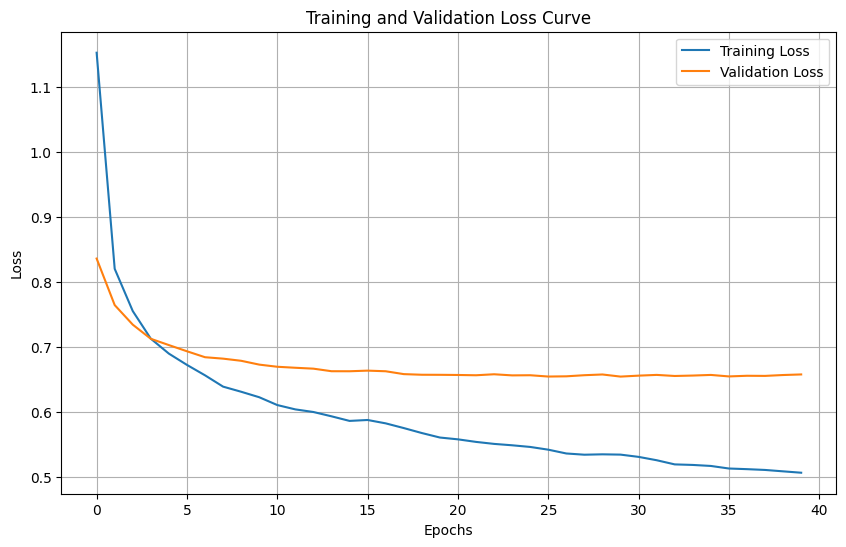

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig('loss_graph.png')
plt.show()

# Testing and Evaluation

In [10]:
model.load_state_dict(torch.load(Config.model_save_path))
model.eval()

test_dataset = VideoQADataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size)

all_preds = []
all_labels = []
test_loss = 0
examples = []
bleu_scores = [] 

with torch.no_grad():
    test_progress_bar = tqdm(test_loader, desc="Testing")
    for batch in test_progress_bar:
        video = batch['video'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = input_ids 

        outputs = model(video, input_ids, attention_mask, labels=labels)
        test_loss += outputs.loss.item()

        preds = torch.argmax(outputs.logits, dim=-1)
        predicted_tokens = preds.cpu().numpy()
        label_tokens = labels.cpu().numpy()


        # Decode tokens and calculate BLEU
        for i in range(len(predicted_tokens)):
            predicted_answer = tokenizer.decode(predicted_tokens[i], skip_special_tokens=True)
            actual_answer = test_df.iloc[test_progress_bar.n * Config.batch_size + i]['refined_answer']

            # Calculate BLEU score for each sample
            try: 
                bleu = sentence_bleu([actual_answer.split()], predicted_answer.split(), smoothing_function=Config.bleu_smoothing) # Use smoothing from config
                bleu_scores.append(bleu)
            except Exception as e:
                print(f"Error calculating BLEU score for example: {e}")
                bleu_scores.append(0.0) 

        all_preds.extend(predicted_tokens)
        all_labels.extend(label_tokens)


        # Save first 3 examples
        if len(examples) < 3 and test_progress_bar.n < 3 :
            for i in range(min(3, len(video))):
                examples.append({
                    'question': test_df.iloc[test_progress_bar.n * Config.batch_size + i]['questions'],
                    'predicted': tokenizer.decode(predicted_tokens[i], skip_special_tokens=True),
                    'actual': test_df.iloc[test_progress_bar.n * Config.batch_size + i]['refined_answer']
                })

# Calculate average BLEU score
average_bleu = np.mean(bleu_scores) if bleu_scores else 0.0


print("\nTest Results:")
print(f"Loss: {test_loss/len(test_loader):.4f}")
print(f"BLEU Score: {average_bleu:.4f}") 


print("\nExample Predictions:")
for ex in examples:
    print(f"\nQuestion: {ex['question']}")
    print(f"Predicted: {ex['predicted']}")
    print(f"Actual: {ex['actual']}")

print(f"\nSaved full results to {Config.results_file}")
print(f"Loss graph saved to loss_graph.png")
print(f"Best checkpoint saved in {Config.best_checkpoint_path}")
print(f"Best model saved to {Config.model_save_path}")
print(f"Final model saved to {Config.final_model_path}")

<ipython-input-10-8e62642c04b3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Config.model_save_path))
Testing: 100%|██████████| 128/128 


Test Results:
Loss: 0.6594
BLEU Score: 0.1911

Example Predictions:

Question: How many are dancing in the video?
Predicted: Question: What many people dancing in the video? Answer: In video showcases multiple individuals performing in the Maruni dance performance,
Actual: The video showcases six dancers participating in the Maruni dance performance.

Question: What type of area is depicted?
Predicted: Question: What is of area is depicted? Answer: The area depicted in the video frames is a traditional space or, likely a cultural or performance community cultural for cultural performances, as indicated by the presence of a instruments andsuchally the the Chyabrung drum) and the dressed in traditional Limbu attire,
Actual: The area depicted in the video frames is a performing arts area, likely a stage or a designated space for cultural performances, as evidenced by the presence of musical instruments (specifically, the Chyabrung drum) and performers dressed in traditional Limbu attire.

In [11]:
results = {
    'config': {k: str(v) if not isinstance(v, (int, float, str, bool, list, dict, type(None))) else v for k, v in vars(Config).items()}, # Convert non-serializable config values to strings
    'training_log': training_log,
    'test_metrics': {
        'loss': test_loss/len(test_loader),
        'bleu_score': average_bleu # Save BLEU score
    },
    'examples': examples
}


# Saving the results

In [12]:
with open(Config.results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nSaved full results to {Config.results_file}")
print(f"Loss graph saved to loss_graph.png")
print(f"Checkpoints saved in {Config.checkpoint_dir} directory")
print(f"Best model saved to {Config.model_save_path}")
print(f"Final model saved to {Config.final_model_path}")


Saved full results to training_results.json
Loss graph saved to loss_graph.png
Checkpoints saved in checkpoints directory
Best model saved to video_qa_model.pth
Final model saved to final_video_qa_model.pth
